# Melanoma Classification Project

## Introduction
In this project, our goal is to develop a machine learning model to accurately classify melanoma. Melanoma is a type of skin cancer that can be fatal if not detected early. We will use a dataset containing various features to predict whether a skin lesion is malignant or benign.

## Data
The dataset consists of two CSV files:
- `train.csv`: Contains the training data used to build the model.
- `test.csv`: Contains the test data on which the trained model will make predictions.

### Training Data
The `train.csv` file includes the following columns:
- `image_name`: Name of the image representing the skin lesion.
- `patient_id`: Unique identifier for each patient.
- `sex`: Gender of the patient.
- `age_approx`: Approximate age of the patient at the time of diagnosis.
- `anatom_site_general_challenge`: General anatomical site of the lesion.
- `diagnosis`: Diagnosis of the lesion (target variable).
- `benign_malignant`: Indicates whether the lesion is benign or malignant (target variable).

## Steps

### 1. Data Loading and Preprocessing
- **Loading Data**: Read the `train.csv` and `test.csv` files to load the dataset into memory.
- **Data Cleaning**: Handle missing values and ensure all necessary columns are present for analysis.
- **Feature Engineering**: Create new features from existing ones, such as age groups and categorical encodings of anatomical sites.
- **Data Transformation**: Encode categorical variables and scale numerical features as required by the machine learning algorithms.

### 2. Exploratory Data Analysis (EDA)
- **Visualize Data**: Use plots and charts to understand the distribution of the target variable (`diagnosis`), age distribution (`age_approx`), and relationships between features and the target.

### 3. Model Training
- **Model Selection**: Choose appropriate models for classification, such as XGBoost and Random Forests, due to their effectiveness in handling both numerical and categorical data.
- **Hyperparameter Tuning**: Use techniques like Optuna to optimize model hyperparameters, aiming to maximize accuracy and F1 score.
- **Pipeline Construction**: Build an imbalanced-learn pipeline to handle class imbalance, including techniques like SMOTE for oversampling minority classes.

### 4. Model Evaluation
- **Cross-Validation**: Evaluate the model using cross-validation techniques to ensure generalizability and reliability of performance metrics.
- **Performance Metrics**: Calculate metrics such as accuracy, F1 score, confusion matrix, and classification report to assess model performance on validation data.

### 5. Model Deployment and Prediction
- **Save Model**: Once trained, save the final model using joblib for deployment and future predictions.
- **Predictions**: Apply the trained model to the test data (`test.csv`) to predict whether lesions are malignant or benign.
- **Save Predictions**: Save the predictions to a CSV file for further analysis and reporting.

### 6. Conclusion
- Summarize findings, including model performance, insights from feature importance analysis, and potential areas for further improvement or research.

By following these steps, we aim to build an effective melanoma classification model that can assist in early detection and treatment decisions.

## References

- [Optuna Documentation](https://optuna.readthedocs.io/en/stable/)
- [Imbalanced-Learn Documentation](https://imbalanced-learn.org/stable/)
- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/)
- [Random Forest Classifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [Voting Classifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)
- [RFECV Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)
- [SMOTE Documentation](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)
- [Pandas Documentation](https://pandas.pydata.org/docs/)
- [Scikit-Learn Documentation](https://scikit-learn.org/stable/documentation.html)
- [Joblib Documentation](https://joblib.readthedocs.io/en/latest/)
- [Kaggle Melanoma Dataset](https://www.kaggle.com/datasets/amirmohammadparvizi/melanoma/data)



In [1]:
import joblib
import numpy as np
import pandas as pd
from halo import Halo
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from loguru import logger
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import RFECV
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
import optuna

from data_visualization import plot_target_distribution, plot_age_distribution, plot_feature_correlation

# Set up logging
logger.add("logs/melanoma_classification.log", rotation="10 MB")


1

In [2]:
def load_data(train_path, test_path):
    spinner = Halo(text='Loading data...', spinner='dots')
    spinner.start()
    try:
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)
        spinner.succeed('Data loaded successfully')
        return train_df, test_df
    except Exception as e:
        spinner.fail('Failed to load data')
        logger.error(e)
        raise

def preprocess_data(df, is_train=True):
    spinner = Halo(text='Preprocessing data...', spinner='dots')
    spinner.start()
    numeric_features = ['age_approx']
    categorical_features = ['sex', 'anatom_site_general_challenge']

    # Feature extraction
    df['age_group'] = pd.cut(df['age_approx'], bins=[0, 20, 40, 60, 80, np.inf],
                             labels=['0-20', '20-40', '40-60', '60-80', '80+'])
    df['anatom_site_category'] = df['anatom_site_general_challenge'].astype('category').cat.codes

    # Interaction features
    df['sex_site_interaction'] = df['sex'].astype(str) + '_' + df['anatom_site_general_challenge'].astype(str)

    # Check and impute numerical features
    for feature in numeric_features:
        if feature in df.columns:
            imputer = SimpleImputer(strategy='median')
            df[feature] = imputer.fit_transform(df[[feature]]).ravel()
        else:
            logger.warning(f"Warning: {feature} is not present in the DataFrame")

    # Check and impute categorical features
    for feature in categorical_features:
        if feature in df.columns:
            imputer = SimpleImputer(strategy='most_frequent')
            df[feature] = imputer.fit_transform(df[[feature]]).ravel()
        else:
            logger.warning(f"Warning: {feature} is not present in the DataFrame")

    # Encode categorical features if present
    for feature in categorical_features + ['age_group', 'anatom_site_category', 'sex_site_interaction']:
        if feature in df.columns:
            le = LabelEncoder()
            df[feature] = le.fit_transform(df[feature])
        else:
            logger.warning(f"Warning: '{feature}' is not present in the DataFrame")

    # If it's the training data, drop unnecessary columns and define the target
    if is_train:
        drop_columns = ['image_name', 'patient_id', 'lesion_id', 'diagnosis', 'benign_malignant']
        df = df.drop(columns=[col for col in drop_columns if col in df.columns])
        X = df.drop(columns=['target'])
        y = df['target']
        return X, y
    else:
        drop_columns = ['image_name', 'patient_id']
        df = df.drop(columns=[col for col in drop_columns if col in df.columns])
        return df


In [3]:
def analyze_feature_importance(fitted_model, training_data):
    spinner = Halo(text='Analyzing feature importance...', spinner='dots')
    spinner.start()
    importances = fitted_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    logger.info(f"Number of features in training data: {training_data.shape[1]}")
    logger.info(f"Number of importances: {len(importances)}")
    logger.info("Feature ranking:")
    for i in range(min(training_data.shape[1], len(importances))):
        logger.info(f"{i + 1}. feature {indices[i]} ({importances[indices[i]]})")
    spinner.succeed('Feature importance analysis completed')

def objective(trial, X, y):
    # Define the parameter search space
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 50, 200),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 10),
        'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('xgb_subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.7, 1.0)
    }

    rf_params = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 50, 200),
        'max_depth': trial.suggest_int('rf_max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 4),
        'bootstrap': trial.suggest_categorical('rf_bootstrap', [True, False])
    }

    try:
        model_pipeline = ImbPipeline(steps=[
            ('smote', SMOTE(random_state=42)),
            ('rfecv', RFECV(estimator=XGBClassifier(**xgb_params), step=1, cv=5, scoring='accuracy')),
            ('classifier', VotingClassifier(estimators=[
                ('xgb', XGBClassifier(**xgb_params)),
                ('rf', RandomForestClassifier(**rf_params))
            ], voting='soft'))
        ])

        # Perform cross-validation
        cross_val_results = cross_val_score(model_pipeline, X, y, cv=5, scoring='f1')
        logger.info(f"Cross-validation F1 scores: {cross_val_results}")

        return np.mean(cross_val_results)

    except Exception as e:
        logger.error(f"Trial failed with parameters: {trial.params}")
        logger.error(f"Error: {e}")
        return 0.0

def train_model(X_train, y_train, n_trials=100):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=n_trials)
    best_params = study.best_params

    logger.info(f"Best trial F1 score: {study.best_value}")
    logger.info(f"Best trial parameters: {best_params}")

    # Train final model with best parameters
    xgb_best_params = {
        'n_estimators': best_params['xgb_n_estimators'],
        'max_depth': best_params['xgb_max_depth'],
        'learning_rate': best_params['xgb_learning_rate'],
        'subsample': best_params['xgb_subsample'],
        'colsample_bytree': best_params['xgb_colsample_bytree']
    }

    rf_best_params = {
        'n_estimators': best_params['rf_n_estimators'],
        'max_depth': best_params['rf_max_depth'],
        'min_samples_split': best_params['rf_min_samples_split'],
        'min_samples_leaf': best_params['rf_min_samples_leaf'],
        'bootstrap': best_params['rf_bootstrap']
    }

    model_pipeline = ImbPipeline(steps=[
        ('smote', SMOTE(random_state=42)),
        ('rfecv', RFECV(estimator=XGBClassifier(**xgb_best_params), step=1, cv=5, scoring='accuracy')),
        ('classifier', VotingClassifier(estimators=[
            ('xgb', XGBClassifier(**xgb_best_params)),
            ('rf', RandomForestClassifier(**rf_best_params))
        ], voting='soft'))
    ])

    model_pipeline.fit(X_train, y_train)

    return model_pipeline

def evaluate_model(model, X_val, y_val):
    try:
        # Perform cross-validation for evaluation
        cross_val_results = cross_val_score(model, X_val, y_val, cv=5, scoring='f1')
        logger.info(f"Cross-validation F1 scores on validation set: {cross_val_results}")

        # Predict on validation set
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='weighted')
        cm = confusion_matrix(y_val, y_pred)
        cr = classification_report(y_val, y_pred)

        return accuracy, f1, cm, cr

    except Exception as e:
        logger.error(f"Evaluation failed with error: {e}")
        return 0.0, 0.0, np.array([[0, 0], [0, 0]]), "Evaluation failed"


✔ Loading data...⠙ Loading data...⠹ Loading data... Data loaded successfully


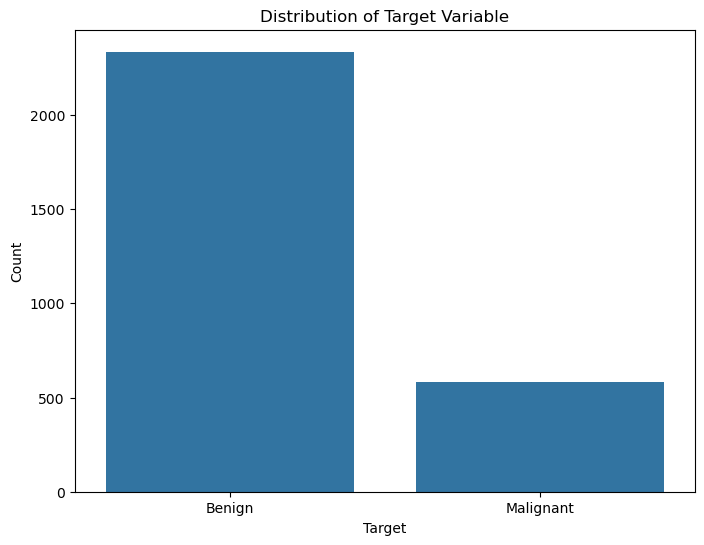

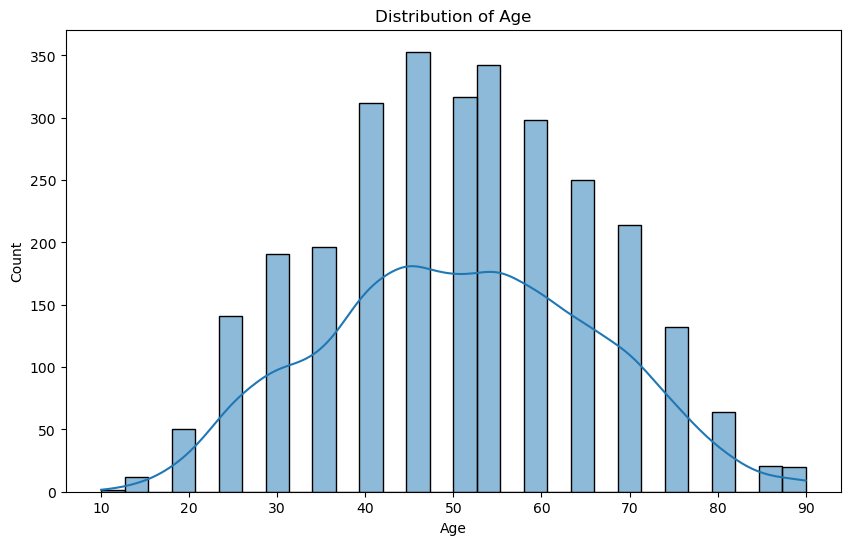

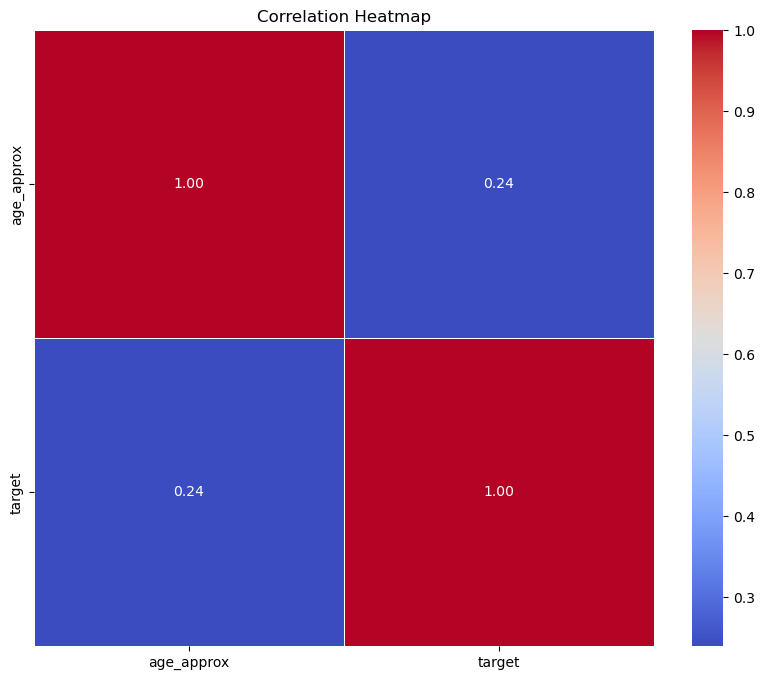

 Preprocessing data...⠙ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...

[I 2024-07-03 11:38:57,089] A new study created in memory with name: no-name-84b59519-02bd-4d8c-a797-5f28d9e9520f


Preprocessing data...⠼⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocess

2024-07-03 11:39:08.066 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44262295 0.36538462 0.37190083 0.39047619 0.45045045]


Preprocessing data... Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...

[I 2024-07-03 11:39:08,460] Trial 0 finished with value: 0.40416700671544187 and parameters: {'xgb_n_estimators': 110, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.062034076762922226, 'xgb_subsample': 0.9873799040197836, 'xgb_colsample_bytree': 0.8160316511791971, 'rf_n_estimators': 87, 'rf_max_depth': 9, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 3, 'rf_bootstrap': True}. Best is trial 0 with value: 0.40416700671544187.


⠧Preprocessing data...⠏. Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data...⠙⠙ Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠦⠦ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏⠏ Preprocessing data...⠋⠋ Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠧⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠙⠙ Preprocessing data... Preprocessing data...⠹⠹ Preproce

2024-07-03 11:39:29.960 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44534413 0.35353535 0.36734694 0.36199095 0.41706161]


⠇⠏ Preprocessing data... Preprocessing data...

[I 2024-07-03 11:39:30,056] Trial 1 finished with value: 0.3890557966932343 and parameters: {'xgb_n_estimators': 164, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.031358867239371736, 'xgb_subsample': 0.9545517282642362, 'xgb_colsample_bytree': 0.8849120940953326, 'rf_n_estimators': 86, 'rf_max_depth': 8, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 1, 'rf_bootstrap': True}. Best is trial 0 with value: 0.40416700671544187.


⠴Preprocessing data...⠇. Preprocessing data...⠙⠋ Preprocessing data... Preprocessing data...⠙⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠦⠴ Preprocessing data...⠦⠧ Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠇⠏ Preprocessing data...⠏⠋ Preprocessing data... Preprocessing data...⠋⠙ Preprocessing data... Preprocessing data...⠹⠙ Preprocessing data...⠸⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠴⠼ Preprocessing data...⠦⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠹⠙ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠴ Preprocessing data...⠧ Preproce

2024-07-03 11:39:40.729 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44354839 0.35353535 0.35390947 0.36111111 0.45070423]
[I 2024-07-03 11:39:40,731] Trial 2 finished with value: 0.39256170842318555 and parameters: {'xgb_n_estimators': 109, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.2317228358302465, 'xgb_subsample': 0.824274318599074, 'xgb_colsample_bytree': 0.8630341855227714, 'rf_n_estimators': 96, 'rf_max_depth': 9, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 4, 'rf_bootstrap': False}. Best is trial 0 with value: 0.40416700671544187.


Preprocessing data...⠇. Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data...⠇⠧ Preprocessing data...⠇⠏ Preprocessing data...⠏⠋ Preprocessing data... Preprocessing data...⠙⠋ Preprocessing data... Preprocessing data...⠹⠙ Preprocessing data...⠸⠹ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠦⠴ Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠏⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼⠸ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏⠋ Preprocessing data... Preprocessing data...⠙⠋ Preprocessing data...⠹⠙ Preprocessing data...⠹ Preprocessing data...⠸⠼ Preprocessing data...⠴ Preproces

2024-07-03 11:41:26.131 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44715447 0.34871795 0.38554217 0.36199095 0.42922374]


[I 2024-07-03 11:41:26,160] Trial 3 finished with value: 0.394525856691169 and parameters: {'xgb_n_estimators': 185, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.02795286107329247, 'xgb_subsample': 0.8962585571989687, 'xgb_colsample_bytree': 0.8878928618714942, 'rf_n_estimators': 169, 'rf_max_depth': 6, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 2, 'rf_bootstrap': False}. Best is trial 0 with value: 0.40416700671544187.


⠏ Preprocessing data.... Preprocessing data...⠧⠴ Preprocessing data... Preprocessing data...⠦⠇ Preprocessing data... Preprocessing data...⠧⠏ Preprocessing data... Preprocessing data...⠇⠋ Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠼⠦ Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠇⠦ Preprocessing data... Preprocessing data...⠏ Preprocessing data...⠋⠇ Preprocessing data... Preprocessing data...⠏⠙ Preprocessing data... Preprocessing data...⠋⠹ Preprocessing data... Preprocessing data...⠙⠸ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠴⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing 

2024-07-03 11:42:41.617 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.42798354 0.34554974 0.37096774 0.36866359 0.43119266]


⠸⠋ Preprocessing data... Preprocessing data...

[I 2024-07-03 11:42:41,738] Trial 4 finished with value: 0.38887145485410685 and parameters: {'xgb_n_estimators': 156, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.2695051809297483, 'xgb_subsample': 0.7194310208556135, 'xgb_colsample_bytree': 0.9304826069072629, 'rf_n_estimators': 140, 'rf_max_depth': 5, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 2, 'rf_bootstrap': False}. Best is trial 0 with value: 0.40416700671544187.


2024-07-03 11:43:43.981 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.46351931 0.35820896 0.38135593 0.35897436 0.44343891]


⠙ Preprocessing data...⠹ Preprocessing data...

[I 2024-07-03 11:43:43,996] Trial 5 finished with value: 0.4010994947466999 and parameters: {'xgb_n_estimators': 120, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.25133707004124767, 'xgb_subsample': 0.9824444143759864, 'xgb_colsample_bytree': 0.8261156303269809, 'rf_n_estimators': 149, 'rf_max_depth': 3, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 2, 'rf_bootstrap': False}. Best is trial 0 with value: 0.40416700671544187.


⠸Preprocessing data....⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data... Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠧⠦ Preprocessing data... Preprocessing data...⠧⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹⠸ Preprocessing data... Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠴⠼ Preprocessing data...⠦ Preprocessing data...⠴ Preprocessing data... Preprocessi

2024-07-03 11:44:42.493 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44262295 0.35175879 0.36065574 0.36697248 0.41545894]
[I 2024-07-03 11:44:42,506] Trial 6 finished with value: 0.38749377935134544 and parameters: {'xgb_n_estimators': 84, 'xgb_max_depth': 7, 'xgb_learning_rate': 0.03473779644169994, 'xgb_subsample': 0.7062141035887971, 'xgb_colsample_bytree': 0.8302261830744604, 'rf_n_estimators': 151, 'rf_max_depth': 10, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 0 with value: 0.40416700671544187.


Preprocessing data...⠏. Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠼⠸ Preprocessing data...⠴ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠧⠦ Preprocessing data... Preprocessing data...⠧⠇ Preprocessing data...⠇⠏ Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠙ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠴⠼ Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data..

2024-07-03 11:45:47.017 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.448      0.37142857 0.38554217 0.38181818 0.41509434]


⠋⠋ Preprocessing data... Preprocessing data...

[I 2024-07-03 11:45:47,024] Trial 7 finished with value: 0.4003766523088187 and parameters: {'xgb_n_estimators': 163, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.2636179709065409, 'xgb_subsample': 0.8876601854963347, 'xgb_colsample_bytree': 0.8819987090759492, 'rf_n_estimators': 146, 'rf_max_depth': 5, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 1, 'rf_bootstrap': True}. Best is trial 0 with value: 0.40416700671544187.


Preprocessing data...⠸ Preprocessing data...⠹⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠴⠴ Preprocessing data...⠦⠦ Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠏⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠧⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙⠙ Preprocessing data...⠹⠹ Preprocessing data...⠸⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data... Preprocessing d

2024-07-03 11:47:24.963 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.42570281 0.33333333 0.35555556 0.30522088 0.46728972]


Preprocessing data..... Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴⠦ Preprocessing data...⠧⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data...

[I 2024-07-03 11:47:25,353] Trial 8 finished with value: 0.3774204606588347 and parameters: {'xgb_n_estimators': 163, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.1425890117788525, 'xgb_subsample': 0.9405953831970123, 'xgb_colsample_bytree': 0.7328853207134169, 'rf_n_estimators': 137, 'rf_max_depth': 9, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 1, 'rf_bootstrap': True}. Best is trial 0 with value: 0.40416700671544187.


⠙reprocessing data...⠏⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠇ Preprocessing data...⠋⠏ Preprocessing data...⠙ Preprocessing data...⠋ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠴ Preprocessing data...⠧⠦ Preprocessing data... Preprocessing data...⠇⠧ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠋ Preprocessing data...⠹⠙ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessi

2024-07-03 11:49:00.432 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.4497992  0.3627451  0.39330544 0.36697248 0.40952381]
[I 2024-07-03 11:49:00,438] Trial 9 finished with value: 0.39646920414898756 and parameters: {'xgb_n_estimators': 128, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.1993599563315242, 'xgb_subsample': 0.7884748964131846, 'xgb_colsample_bytree': 0.9688486576880009, 'rf_n_estimators': 87, 'rf_max_depth': 4, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 0 with value: 0.40416700671544187.


⠋Preprocessing data...⠏⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data... Preprocessing data... Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧⠧ Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data... Preprocessing data...⠋ Preprocessing data.

2024-07-03 11:49:45.671 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44715447 0.33862434 0.37246964 0.3652968  0.41509434]


 Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...

[I 2024-07-03 11:49:46,069] Trial 10 finished with value: 0.38772791781443877 and parameters: {'xgb_n_estimators': 54, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.11210558356970271, 'xgb_subsample': 0.9954284908101447, 'xgb_colsample_bytree': 0.7418690881053407, 'rf_n_estimators': 57, 'rf_max_depth': 7, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 3, 'rf_bootstrap': True}. Best is trial 0 with value: 0.40416700671544187.


Preprocessing data...⠙⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocess

2024-07-03 11:50:24.092 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.42379182 0.3681592  0.38983051 0.39473684 0.44144144]
[I 2024-07-03 11:50:24,096] Trial 11 finished with value: 0.4035919635125437 and parameters: {'xgb_n_estimators': 113, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.10607745338128548, 'xgb_subsample': 0.990746938200252, 'xgb_colsample_bytree': 0.7974284302258768, 'rf_n_estimators': 108, 'rf_max_depth': 3, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 3, 'rf_bootstrap': False}. Best is trial 0 with value: 0.40416700671544187.


Preprocessing data...⠙⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏⠋ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠹⠙ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼⠴ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠧⠦ Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠇⠏ Preprocessing data... Preprocessing data...⠋⠏ Preprocessing

2024-07-03 11:51:14.731 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.43265306 0.35294118 0.38983051 0.38983051 0.44642857]
[I 2024-07-03 11:51:14,737] Trial 12 finished with value: 0.40233676521456047 and parameters: {'xgb_n_estimators': 86, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.09877343854283917, 'xgb_subsample': 0.9210129539997397, 'xgb_colsample_bytree': 0.7828516158279741, 'rf_n_estimators': 109, 'rf_max_depth': 3, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 3, 'rf_bootstrap': False}. Best is trial 0 with value: 0.40416700671544187.


. Preprocessing data...⠇⠏ Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠙⠋ Preprocessing data... Preprocessing data... Preprocessing data...⠸⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠼ Preprocessing data...⠦ Preprocessing data...⠴ Preprocessing data...⠧⠦ Preprocessing data...⠧⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙⠋ Preprocessing data... Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠼⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠇⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing d

2024-07-03 11:51:21.898 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.43650794 0.37073171 0.38735178 0.38277512 0.43946188]
[I 2024-07-03 11:51:21,900] Trial 13 finished with value: 0.4033656851012866 and parameters: {'xgb_n_estimators': 100, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.08549989865187715, 'xgb_subsample': 0.9963874090869871, 'xgb_colsample_bytree': 0.7851181570032051, 'rf_n_estimators': 58, 'rf_max_depth': 7, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 3, 'rf_bootstrap': False}. Best is trial 0 with value: 0.40416700671544187.


⠧ Preprocessing data...⠹ Preprocessing data...⠼ Preprocessing data...⠸ Preprocessing data...⠴ Preprocessing data...⠼ Preprocessing data...⠦ Preprocessing data...⠴ Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing data...⠇ Preprocessing data...⠋ Preprocessing data...⠏ Preprocessing data...⠙⠋ Preprocessing data... Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠹⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠏⠋ Preprocessing data... Preprocessing data...⠙⠋ Preprocessing data... Preprocessing data...⠹⠙ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠼⠴ Preprocessing dat

2024-07-03 11:51:31.825 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.45299145 0.35233161 0.3755102  0.37272727 0.44144144]
[I 2024-07-03 11:51:31,827] Trial 14 finished with value: 0.39900039549188326 and parameters: {'xgb_n_estimators': 137, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.07540697072846275, 'xgb_subsample': 0.865269615943978, 'xgb_colsample_bytree': 0.7874464432535978, 'rf_n_estimators': 116, 'rf_max_depth': 10, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 0 with value: 0.40416700671544187.


Preprocessing data....Preprocessing data...⠋⠏ Preprocessing data... Preprocessing data...⠙⠋ Preprocessing data... Preprocessing data...⠙⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠧⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠏⠇ Preprocessing data...⠋ Preprocessing data...⠙⠋ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠴⠼ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data...⠋⠙ Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data..

2024-07-03 11:51:38.718 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44827586 0.33862434 0.35146444 0.36936937 0.41706161]


 Preprocessing data...⠋ Preprocessing data...

[I 2024-07-03 11:51:38,814] Trial 15 finished with value: 0.38495912331670495 and parameters: {'xgb_n_estimators': 60, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.16736028828869481, 'xgb_subsample': 0.9521147284079153, 'xgb_colsample_bytree': 0.8205444501802802, 'rf_n_estimators': 80, 'rf_max_depth': 8, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 3, 'rf_bootstrap': False}. Best is trial 0 with value: 0.40416700671544187.


 Preprocessing data...⠹. Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠇⠧ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏⠇ Preprocessing data... Preprocessing data...⠋ Preprocessing data... Preprocessing data... Preprocessing data...⠹⠙ Preprocessing data... Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠦ Preprocessing da

2024-07-03 11:51:47.456 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44015444 0.37073171 0.376      0.37391304 0.43062201]
[I 2024-07-03 11:51:47,458] Trial 16 finished with value: 0.39828424010383046 and parameters: {'xgb_n_estimators': 80, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.13730683961892703, 'xgb_subsample': 0.8077085446315942, 'xgb_colsample_bytree': 0.7178314612409121, 'rf_n_estimators': 107, 'rf_max_depth': 6, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 3, 'rf_bootstrap': False}. Best is trial 0 with value: 0.40416700671544187.


Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠴⠼ Preprocessing data... Preprocessing data...⠦⠴ Preprocessing data... Preprocessing data...⠧⠦ Preprocessing data... Preprocessing data... Preprocessing data...⠇⠏ Preprocessing data... Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data... Preprocessing data...⠸⠼ Preprocessing data...⠴⠼ Preprocessing data... Preprocessing data... Preprocessing dat

2024-07-03 11:51:57.750 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44       0.34196891 0.39330544 0.39285714 0.44144144]
[I 2024-07-03 11:51:57,752] Trial 17 finished with value: 0.4019145871092453 and parameters: {'xgb_n_estimators': 143, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.0614337008650365, 'xgb_subsample': 0.7526282042336748, 'xgb_colsample_bytree': 0.7585582823625253, 'rf_n_estimators': 69, 'rf_max_depth': 4, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 0 with value: 0.40416700671544187.


⠹Preprocessing data...⠙ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing data...⠋⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing

2024-07-03 11:52:17.256 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.43265306 0.34343434 0.34334764 0.30588235 0.46296296]
[I 2024-07-03 11:52:17,258] Trial 18 finished with value: 0.3776560720095903 and parameters: {'xgb_n_estimators': 105, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.17510631801935092, 'xgb_subsample': 0.9163725091476037, 'xgb_colsample_bytree': 0.9295532037414502, 'rf_n_estimators': 126, 'rf_max_depth': 8, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 3, 'rf_bootstrap': False}. Best is trial 0 with value: 0.40416700671544187.


⠹⠸reprocessing data...⠧. Preprocessing data...⠼⠴ Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠦⠧ Preprocessing data... Preprocessing data...⠇⠧ Preprocessing data...⠏⠇ Preprocessing data...⠋⠏ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data...⠇ Preprocessing data...⠋ Preprocessing data...⠏ Preprocessing data...⠙ Preprocessing data...⠋ Preprocessing data...⠹ Preprocessing data...⠙ Preprocessing data...⠸⠹ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessin

2024-07-03 11:52:27.545 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.45081967 0.34224599 0.36065574 0.3652968  0.45794393]
[I 2024-07-03 11:52:27,548] Trial 19 finished with value: 0.39539242560549825 and parameters: {'xgb_n_estimators': 119, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.11898475400886924, 'xgb_subsample': 0.965929699854903, 'xgb_colsample_bytree': 0.8093465723852551, 'rf_n_estimators': 194, 'rf_max_depth': 9, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 0 with value: 0.40416700671544187.


Preprocessing data..... Preprocessing data...⠼⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠇ Preprocessing data...⠋⠏ Preprocessing data...⠙ Preprocessing data...⠋ Preprocessing data... Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data... Preprocessing data...⠼⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠹⠙ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessin

2024-07-03 11:52:38.252 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44787645 0.37681159 0.3852459  0.37142857 0.44343891]
[I 2024-07-03 11:52:38,254] Trial 20 finished with value: 0.4049602858348823 and parameters: {'xgb_n_estimators': 70, 'xgb_max_depth': 7, 'xgb_learning_rate': 0.055178816540621026, 'xgb_subsample': 0.8676756240262158, 'xgb_colsample_bytree': 0.8597200358441388, 'rf_n_estimators': 101, 'rf_max_depth': 5, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 20 with value: 0.4049602858348823.


⠏ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹⠸ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠴⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data... Preprocessing data...⠹⠙ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦⠴ Preprocessing data... Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇⠏ Preprocessing data... Preprocessing data...⠏⠋ Preprocessing data... Preprocessing data...⠙⠋ Preprocessing data... Preprocessing data...⠹⠙ Preprocessing data...⠸⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠴⠼ Preprocessing data... Preprocessing data.

2024-07-03 11:52:52.092 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.456      0.38139535 0.3852459  0.38053097 0.42727273]
[I 2024-07-03 11:52:52,095] Trial 21 finished with value: 0.40608899024012163 and parameters: {'xgb_n_estimators': 71, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.056908908024162624, 'xgb_subsample': 0.8310585405070905, 'xgb_colsample_bytree': 0.8528373430276712, 'rf_n_estimators': 96, 'rf_max_depth': 4, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 21 with value: 0.40608899024012163.


⠋Preprocessing data...⠇ Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠧⠧ Preprocessing data... Preprocessing data...⠇⠇ Preprocessing data... Preprocessing data...⠏⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠸⠸ Preprocessing data... Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data... Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼⠼ Preprocessing data...⠴ Preprocessing data

2024-07-03 11:53:08.806 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.45238095 0.38888889 0.3852459  0.38222222 0.44343891]
[I 2024-07-03 11:53:08,811] Trial 22 finished with value: 0.41043537583171136 and parameters: {'xgb_n_estimators': 67, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.04552107169030811, 'xgb_subsample': 0.8548015420090309, 'xgb_colsample_bytree': 0.8529749234278489, 'rf_n_estimators': 74, 'rf_max_depth': 5, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


. Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠸⠸ Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠦⠦ Preprocessing data... Preprocessing data...⠧⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠋⠋ Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴⠴ Preprocessing data... Preprocessing data...⠦⠦ Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data... Preprocessing data...⠙⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠸⠸ Preprocessing data...⠼⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦⠦ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing

2024-07-03 11:53:20.684 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.4453125  0.36453202 0.39516129 0.37344398 0.44155844]
[I 2024-07-03 11:53:20,686] Trial 23 finished with value: 0.40400164699758906 and parameters: {'xgb_n_estimators': 72, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.01046466877876822, 'xgb_subsample': 0.8471303498662992, 'xgb_colsample_bytree': 0.8610679842334475, 'rf_n_estimators': 71, 'rf_max_depth': 5, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


 Preprocessing data...⠙. Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸⠸ Preprocessing data...⠼⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data...⠋⠋ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴⠴ Preprocessing data

2024-07-03 11:53:31.808 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44015444 0.38679245 0.38367347 0.37668161 0.44144144]


 Preprocessing data...⠹ Preprocessing data...

[I 2024-07-03 11:53:31,896] Trial 24 finished with value: 0.4057486836327202 and parameters: {'xgb_n_estimators': 66, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.054080628196913005, 'xgb_subsample': 0.8599791839023102, 'xgb_colsample_bytree': 0.9115889156753533, 'rf_n_estimators': 98, 'rf_max_depth': 4, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


 Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠏⠏ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data...⠴⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠧⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠋⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦⠦ Preprocessing data...⠧⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data.

2024-07-03 11:53:39.565 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44444444 0.38793103 0.38888889 0.3968254  0.42922374]
[I 2024-07-03 11:53:39,567] Trial 25 finished with value: 0.40946270178674526 and parameters: {'xgb_n_estimators': 50, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.011997593981939968, 'xgb_subsample': 0.8428776547973934, 'xgb_colsample_bytree': 0.917708242116425, 'rf_n_estimators': 50, 'rf_max_depth': 4, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


. Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠏⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠴⠴ Preprocessing data...⠦⠦ Preprocessing data...⠧⠧ Preprocessing data...⠇⠇ Preprocessing data... Preprocessing data...⠏⠏ Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data... Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠏⠏ Preprocessing data... Preprocessing 

2024-07-03 11:53:47.593 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.4453125  0.38222222 0.38683128 0.37656904 0.42857143]
[I 2024-07-03 11:53:47,598] Trial 26 finished with value: 0.4039012928341438 and parameters: {'xgb_n_estimators': 50, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.017765106288745447, 'xgb_subsample': 0.7819598559316533, 'xgb_colsample_bytree': 0.9994684382795694, 'rf_n_estimators': 50, 'rf_max_depth': 4, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


 Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocess

2024-07-03 11:54:02.571 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.448      0.3681592  0.3943662  0.37104072 0.44343891]
[I 2024-07-03 11:54:02,573] Trial 27 finished with value: 0.4050010078344496 and parameters: {'xgb_n_estimators': 93, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.043583954624332316, 'xgb_subsample': 0.8323835946852168, 'xgb_colsample_bytree': 0.9103918220997839, 'rf_n_estimators': 72, 'rf_max_depth': 6, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


 Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocess

2024-07-03 11:54:13.489 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44705882 0.37719298 0.38888889 0.3800905  0.44347826]
[I 2024-07-03 11:54:13,491] Trial 28 finished with value: 0.40734189069631255 and parameters: {'xgb_n_estimators': 61, 'xgb_max_depth': 7, 'xgb_learning_rate': 0.011789117282333955, 'xgb_subsample': 0.8070228716946102, 'xgb_colsample_bytree': 0.9640349549448028, 'rf_n_estimators': 64, 'rf_max_depth': 4, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


 Preprocessing data...⠼⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠸⠹ Preprocessing data...⠼ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing 

2024-07-03 11:54:23.171 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44106464 0.37948718 0.38888889 0.37735849 0.44144144]
[I 2024-07-03 11:54:23,173] Trial 29 finished with value: 0.4056481278333635 and parameters: {'xgb_n_estimators': 58, 'xgb_max_depth': 7, 'xgb_learning_rate': 0.012722630760844764, 'xgb_subsample': 0.7659606326596817, 'xgb_colsample_bytree': 0.9647630092811205, 'rf_n_estimators': 61, 'rf_max_depth': 5, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


⠹Preprocessing data...⠼ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing data...⠇ Preprocessing data...⠋⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸⠼ Preprocessing data...⠼⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠦⠧ Preprocessing data... Preprocessing data...⠇⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏⠋ Preprocessing data... Preprocessing data...⠋⠙ Preprocessing data...⠹ Preprocessing data...⠙ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼⠸ Preprocessing data... Preprocessing data...⠼⠴ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data... Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data... Preprocessing da

2024-07-03 11:54:38.091 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.43548387 0.37735849 0.37974684 0.3442623  0.41346154]
[I 2024-07-03 11:54:38,093] Trial 30 finished with value: 0.3900626061040646 and parameters: {'xgb_n_estimators': 94, 'xgb_max_depth': 7, 'xgb_learning_rate': 0.299387057134759, 'xgb_subsample': 0.807736224355743, 'xgb_colsample_bytree': 0.9651436153684514, 'rf_n_estimators': 77, 'rf_max_depth': 3, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


. Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧⠇ Preprocessing data...⠇⠏ Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠹⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴⠼ Preprocessing data...⠦⠴ Preprocessing data... Preprocessing data...⠦⠧ Preprocessing data... Preprocessing data...⠇⠧ Preprocessing data... Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠋ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠹⠙ Preprocessing data...⠸ Preprocessing data...⠹ Preprocessing data...⠼⠸ Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing

2024-07-03 11:54:56.746 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.4497992  0.37438424 0.3852459  0.375      0.42922374]
[I 2024-07-03 11:54:56,748] Trial 31 finished with value: 0.40273061583438646 and parameters: {'xgb_n_estimators': 75, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.07861687093271327, 'xgb_subsample': 0.8377702441845272, 'xgb_colsample_bytree': 0.9351527505261351, 'rf_n_estimators': 51, 'rf_max_depth': 4, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


Preprocessing data...⠧ Preprocessing data...⠋ Preprocessing data...⠏ Preprocessing data...⠙ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠴⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing data...⠇ Preprocessing data...⠋ Preprocessing data...⠏ Preprocessing data...⠙ Preprocessing data...⠋ Preprocessing data...⠹ Preprocessing data...⠙ Preprocessing data...⠸ Preprocessing data...⠹ Preprocessing data...⠼ Preprocessing data...⠸ Preprocessing data...⠴ Preprocessing data...⠼ Preprocessing data...⠦ Preprocessing data...⠴ Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing data...⠇ Preprocessing data...⠋ Preprocessing data...⠏ Preprocessing

2024-07-03 11:55:08.131 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.43678161 0.38139535 0.38709677 0.37719298 0.44144144]
[I 2024-07-03 11:55:08,134] Trial 32 finished with value: 0.4047816312247484 and parameters: {'xgb_n_estimators': 64, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.040714198597005716, 'xgb_subsample': 0.8140499201030993, 'xgb_colsample_bytree': 0.8445691347908704, 'rf_n_estimators': 64, 'rf_max_depth': 4, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


⠸ Preprocessing data...⠴ Preprocessing data...⠼ Preprocessing data...⠦ Preprocessing data...⠴ Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing data...⠇ Preprocessing data...⠋ Preprocessing data...⠏ Preprocessing data...⠙ Preprocessing data...⠋ Preprocessing data...⠹ Preprocessing data...⠙ Preprocessing data...⠹⠸ Preprocessing data...⠸ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠋ Preprocessing data... Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠧⠦ Preprocessing data...⠧⠇ Preprocessing data...⠇⠏ Preprocessing data... Preprocessing data...⠏ Preprocessing data...⠋ Preprocessi

2024-07-03 11:55:15.137 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44705882 0.36866359 0.38866397 0.36936937 0.44144144]
[I 2024-07-03 11:55:15,139] Trial 33 finished with value: 0.40303943928432096 and parameters: {'xgb_n_estimators': 50, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.026158638582581335, 'xgb_subsample': 0.8881471145835222, 'xgb_colsample_bytree': 0.8983718208734777, 'rf_n_estimators': 83, 'rf_max_depth': 5, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠼⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠦⠴ Preprocessing data... Preprocessing data...⠧⠦ Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠏⠋ Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠹⠸ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠼⠴ Preprocessing data...⠴⠦ Preprocessing data...⠧⠦ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠙⠋ Preprocessing data... Preprocessin

2024-07-03 11:55:29.919 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.45238095 0.3681592  0.39043825 0.38095238 0.42790698]


⠙

[I 2024-07-03 11:55:29,921] Trial 34 finished with value: 0.4039675522139142 and parameters: {'xgb_n_estimators': 77, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.0703516722728972, 'xgb_subsample': 0.7942685984335964, 'xgb_colsample_bytree': 0.9481788960211178, 'rf_n_estimators': 94, 'rf_max_depth': 4, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧⠇ Preprocessing data... Preprocessing data...⠇⠏ Preprocessing data...⠏⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preproces

2024-07-03 11:55:40.153 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.4497992  0.4        0.38174274 0.37272727 0.42666667]


⠹⠙ Preprocessing data... Preprocessing data...

[I 2024-07-03 11:55:40,206] Trial 35 finished with value: 0.4061871749540599 and parameters: {'xgb_n_estimators': 61, 'xgb_max_depth': 7, 'xgb_learning_rate': 0.04694143730957956, 'xgb_subsample': 0.7422963973826845, 'xgb_colsample_bytree': 0.9973437799798065, 'rf_n_estimators': 67, 'rf_max_depth': 3, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 3, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


 Preprocessing data...⠏. Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏⠇ Preprocessing data... Preprocessing data...⠋⠏ Preprocessing data...⠙ Preprocessing data...⠙⠹ Preprocessing data...⠸⠹ Preprocessing data... Preprocessing data...⠼⠸ Preprocessing data...⠴ Preprocessing data...⠼ Preprocessing data...⠦⠴ Preprocessing data... Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇⠏ Preprocessing data...⠏⠋ Preprocessing data...⠋⠙ Preprocessing data... Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠸⠹ Preprocessing data...⠼⠸ Preprocessing data...⠼⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠏⠇ Preprocess

2024-07-03 11:56:02.278 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44268775 0.38497653 0.3943662  0.3826087  0.42922374]
[I 2024-07-03 11:56:02,280] Trial 36 finished with value: 0.40677258199693583 and parameters: {'xgb_n_estimators': 195, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.03538193358396641, 'xgb_subsample': 0.7385434830745792, 'xgb_colsample_bytree': 0.9978020155699372, 'rf_n_estimators': 66, 'rf_max_depth': 3, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 3, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


Preprocessing data.... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠼ Preprocessing data...⠦ Preprocessing data...⠴ Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing data...⠇ Preprocessing data...⠋ Preprocessing data...⠏ Preprocessing data...⠙ Preprocessing data...⠋ Preprocessing data...⠹ Preprocessing data...⠙ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴⠦ Preprocessing data... Preprocessing data...⠧⠦ Preprocessing data... Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏⠋ Preprocessing data... Preprocessing data...⠋⠙ Preprocessing data...⠹ Preprocessing data...⠙ Preprocessing data...⠸ Preprocessing data...⠹ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing 

2024-07-03 11:56:26.581 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44534413 0.39800995 0.38174274 0.38596491 0.42922374]
[I 2024-07-03 11:56:26,584] Trial 37 finished with value: 0.40805709499311255 and parameters: {'xgb_n_estimators': 200, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.02910235457145553, 'xgb_subsample': 0.7270747926353968, 'xgb_colsample_bytree': 0.9772312716649316, 'rf_n_estimators': 51, 'rf_max_depth': 3, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 3, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


 Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠙ Preprocessing data...⠸ Preprocessing data...⠹ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴⠼ Preprocessing data...⠴⠦ Preprocessing data... Preprocessing data...⠦⠧ Preprocessing data...⠇⠧ Preprocessing data...⠏⠇ Preprocessing data...⠋⠏ Preprocessing data...⠋ Preprocessing data... Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠼⠴ Preprocessing data... Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠇⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙⠋ Preprocessing data... Preprocessing data... Preprocessing data...⠹⠸ Preprocessing data...⠸ Preprocessing data...⠴ Preprocessing data...⠼ Preprocessing data...⠦ Preprocessing data...⠧⠦ Preprocessing data...⠇⠧ Preprocessing data...⠏⠇ Preprocess

2024-07-03 11:56:51.222 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.45783133 0.38497653 0.39285714 0.36097561 0.43946188]
[I 2024-07-03 11:56:51,225] Trial 38 finished with value: 0.4072204974288226 and parameters: {'xgb_n_estimators': 186, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.02582331295179221, 'xgb_subsample': 0.7198473308370719, 'xgb_colsample_bytree': 0.9809074803241749, 'rf_n_estimators': 52, 'rf_max_depth': 6, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 3, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


 Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data... Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦⠧ Preprocessing data...⠧⠇ Preprocessing data...⠇ Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠋ Preprocessing d

2024-07-03 11:57:17.518 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.4497992  0.37735849 0.38554217 0.34632035 0.41346154]


[I 2024-07-03 11:57:17,521] Trial 39 finished with value: 0.394496348161954 and parameters: {'xgb_n_estimators': 175, 'xgb_max_depth': 7, 'xgb_learning_rate': 0.09390320148044581, 'xgb_subsample': 0.7718127304955196, 'xgb_colsample_bytree': 0.9475091848021213, 'rf_n_estimators': 75, 'rf_max_depth': 5, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 3, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


reprocessing data...⠇⠦ Preprocessing data...⠴ Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing data...⠇ Preprocessing data...⠋ Preprocessing data...⠏ Preprocessing data...⠙ Preprocessing data...⠋ Preprocessing data...⠹ Preprocessing data...⠙ Preprocessing data...⠸ Preprocessing data...⠹ Preprocessing data...⠼ Preprocessing data...⠸ Preprocessing data...⠴ Preprocessing data...⠼ Preprocessing data...⠦ Preprocessing data...⠴ Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing data...⠇ Preprocessing data...⠋ Preprocessing data...⠏ Preprocessing data...⠙ Preprocessing data...⠋ Preprocessing data...⠹ Preprocessing data...⠙ Preprocessing data...⠸ Preprocessing data...⠹ Preprocessing data...⠼ Preprocessing data...⠸ Preprocessing data...⠴ Preprocessing data...⠼ Preprocessing data...⠦ Preprocessing data...⠴ Preprocessing data...⠧ Preprocessi

2024-07-03 11:57:33.867 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.4497992  0.38888889 0.38679245 0.34934498 0.42592593]
[I 2024-07-03 11:57:33,869] Trial 40 finished with value: 0.40015028851961815 and parameters: {'xgb_n_estimators': 154, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.2196879945848065, 'xgb_subsample': 0.9053623551439077, 'xgb_colsample_bytree': 0.8816879924120083, 'rf_n_estimators': 89, 'rf_max_depth': 3, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


Preprocessing data...⠦⠇ Preprocessing data...⠋ Preprocessing data...⠏ Preprocessing data...⠙ Preprocessing data...⠋ Preprocessing data...⠹ Preprocessing data...⠙ Preprocessing data...⠸ Preprocessing data...⠹ Preprocessing data...⠼ Preprocessing data...⠸ Preprocessing data...⠴ Preprocessing data...⠼ Preprocessing data...⠦ Preprocessing data...⠴ Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing data...⠇ Preprocessing data...⠋ Preprocessing data...⠏ Preprocessing data...⠙ Preprocessing data...⠋ Preprocessing data...⠹ Preprocessing data...⠙ Preprocessing data...⠸ Preprocessing data...⠹ Preprocessing data...⠼ Preprocessing data...⠸ Preprocessing data...⠴ Preprocessing data...⠼ Preprocessing data...⠦ Preprocessing data...⠴ Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing data...⠇ Preprocessing data...⠋ Preprocessing data...⠏ Preprocess

2024-07-03 11:57:56.659 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.464      0.38709677 0.38367347 0.3592233  0.41509434]
[I 2024-07-03 11:57:56,661] Trial 41 finished with value: 0.4018175768349638 and parameters: {'xgb_n_estimators': 198, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.02857037414574279, 'xgb_subsample': 0.7035250297749172, 'xgb_colsample_bytree': 0.9846938718249301, 'rf_n_estimators': 53, 'rf_max_depth': 6, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 3, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


⠏Preprocessing data....⠧ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠏⠋ Preprocessing data...⠋⠙ Preprocessing data... Preprocessing data...⠹⠙ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇⠏ Preprocessing data... Preprocessing data...⠏⠋ Preprocessing data...⠋⠙ Preprocessing data... Preprocessing data...⠙⠹ Preprocessing data...⠸⠹ Preprocessing data...⠼ Preprocessing data... Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠋⠏ Preprocessing data... Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠙ Preprocessing data... Preprocessing

2024-07-03 11:58:19.753 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.46721311 0.38139535 0.38367347 0.3592233  0.41284404]
[I 2024-07-03 11:58:19,755] Trial 42 finished with value: 0.40086985412943693 and parameters: {'xgb_n_estimators': 189, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.02331466771019986, 'xgb_subsample': 0.7118763677970913, 'xgb_colsample_bytree': 0.9753333987383828, 'rf_n_estimators': 57, 'rf_max_depth': 6, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


 Preprocessing data...⠹⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠹⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠼ Preprocessing data...⠦ Preprocessing data...⠴ Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data... Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠋⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠹⠙ Preprocessing data...⠸⠹ Preprocessing data...⠼⠸ Preprocessing data...⠴⠼ Preprocessing data... Preprocessing data...⠦⠴ Preprocessing data... Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing data...⠋⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼⠴ Preprocess

2024-07-03 11:58:50.775 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44715447 0.35353535 0.35779817 0.34632035 0.41509434]
[I 2024-07-03 11:58:50,778] Trial 43 finished with value: 0.38398053523213427 and parameters: {'xgb_n_estimators': 184, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.03693904111564014, 'xgb_subsample': 0.7284097481092235, 'xgb_colsample_bytree': 0.9501141207570918, 'rf_n_estimators': 61, 'rf_max_depth': 7, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 3, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠏ Preprocessing data...⠙ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠸⠹ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠙⠋ Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹⠸ Preprocessing data...⠸⠼ Preprocessing data...⠴⠼ Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧⠇ Preprocessing data...⠏⠇ Preprocessing data... Preprocessing d

2024-07-03 11:59:14.936 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.43678161 0.39252336 0.39525692 0.36619718 0.44144144]
[I 2024-07-03 11:59:14,938] Trial 44 finished with value: 0.40644010304349276 and parameters: {'xgb_n_estimators': 179, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.013974127026280146, 'xgb_subsample': 0.7299235015570311, 'xgb_colsample_bytree': 0.9811239603698527, 'rf_n_estimators': 50, 'rf_max_depth': 5, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


Preprocessing data...⠇⠦ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing data...⠇ Preprocessing data...⠋ Preprocessing data...⠏ Preprocessing data...⠙ Preprocessing data...⠋ Preprocessing data...⠹ Preprocessing data...⠙ Preprocessing data...⠸ Preprocessing data...⠹ Preprocessing data...⠼ Preprocessing data...⠸ Preprocessing data...⠴ Preprocessing data...⠼ Preprocessing data...⠦ Preprocessing data...⠴ Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠇⠏ Preprocessing data...⠏⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data... Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠸ Preprocessing data...⠴ Preprocessing data...⠼ Preprocessing data...⠦⠴ Preprocessing data... Preprocessing data...⠧⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing

2024-07-03 11:59:39.661 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.448      0.37735849 0.37860082 0.38095238 0.41346154]
[I 2024-07-03 11:59:39,664] Trial 45 finished with value: 0.399674646605045 and parameters: {'xgb_n_estimators': 169, 'xgb_max_depth': 7, 'xgb_learning_rate': 0.06503323156015722, 'xgb_subsample': 0.7564655501644394, 'xgb_colsample_bytree': 0.914455768547058, 'rf_n_estimators': 59, 'rf_max_depth': 4, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 1, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


⠇ Preprocessing data...⠋ Preprocessing data...⠏ Preprocessing data...⠙ Preprocessing data...⠋ Preprocessing data...⠹ Preprocessing data...⠙ Preprocessing data...⠸ Preprocessing data...⠹ Preprocessing data...⠼ Preprocessing data...⠸ Preprocessing data...⠴ Preprocessing data...⠼ Preprocessing data...⠦ Preprocessing data...⠴ Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing data...⠇ Preprocessing data...⠋ Preprocessing data...⠏ Preprocessing data...⠙ Preprocessing data...⠋ Preprocessing data...⠹ Preprocessing data...⠙ Preprocessing data...⠸ Preprocessing data...⠹ Preprocessing data...⠼ Preprocessing data...⠸ Preprocessing data...⠴ Preprocessing data...⠼ Preprocessing data...⠦ Preprocessing data...⠴ Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing data...⠇ Preprocessing data...⠋ Preprocessing data...⠏ Preprocessing data...⠙ Preproces

2024-07-03 12:00:08.698 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.45238095 0.36633663 0.3652968  0.37104072 0.41509434]
[I 2024-07-03 12:00:08,700] Trial 46 finished with value: 0.39402989066036576 and parameters: {'xgb_n_estimators': 200, 'xgb_max_depth': 7, 'xgb_learning_rate': 0.025381996402134767, 'xgb_subsample': 0.8791345445041485, 'xgb_colsample_bytree': 0.957804309612821, 'rf_n_estimators': 166, 'rf_max_depth': 6, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 3, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


⠼Preprocessing data...⠴. Preprocessing data...⠋ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠼⠴ Preprocessing data... Preprocessing data...⠴⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data... Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠙ Preprocessing data...⠸ Preprocessing data...⠹ Preprocessing data...⠼ Preprocessing data...⠸ Preprocessing data...⠴ Preprocessing data...⠼ Preprocessing data...⠴⠦ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing d

2024-07-03 12:00:18.412 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.4488189  0.3853211  0.38888889 0.37837838 0.44144144]
[I 2024-07-03 12:00:18,413] Trial 47 finished with value: 0.408569741452787 and parameters: {'xgb_n_estimators': 87, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.04106488768860367, 'xgb_subsample': 0.818163102653239, 'xgb_colsample_bytree': 0.9371511258605772, 'rf_n_estimators': 79, 'rf_max_depth': 5, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


Preprocessing data...⠧. Preprocessing data...⠦⠴ Preprocessing data...⠧⠦ Preprocessing data... Preprocessing data...⠧⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠏⠋ Preprocessing data... Preprocessing data...⠋⠙ Preprocessing data...⠹ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠇⠧ Preprocessing data...⠏⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠼⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data... Preprocessing dat

2024-07-03 12:00:27.920 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.43478261 0.37614679 0.38709677 0.40692641 0.44144144]
[I 2024-07-03 12:00:27,922] Trial 48 finished with value: 0.40927880404957495 and parameters: {'xgb_n_estimators': 87, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.04423343793372918, 'xgb_subsample': 0.8511790952166979, 'xgb_colsample_bytree': 0.9355366493457394, 'rf_n_estimators': 84, 'rf_max_depth': 3, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


Preprocessing data...⠏⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇⠇ Preprocessing data...⠏ Preprocessing data...⠋⠋ Preprocessing data... Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessi

2024-07-03 12:00:36.969 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.43650794 0.3681592  0.38174274 0.37614679 0.44144144]
[I 2024-07-03 12:00:36,972] Trial 49 finished with value: 0.400799621901903 and parameters: {'xgb_n_estimators': 85, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.08493086776934336, 'xgb_subsample': 0.8489616347868184, 'xgb_colsample_bytree': 0.929577960428335, 'rf_n_estimators': 88, 'rf_max_depth': 3, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 2, 'rf_bootstrap': False}. Best is trial 22 with value: 0.41043537583171136.


 Preprocessing data...⠏⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preproces

2024-07-03 12:00:46.118 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.43478261 0.39047619 0.38554217 0.3930131  0.44144144]
[I 2024-07-03 12:00:46,120] Trial 50 finished with value: 0.4090511019449329 and parameters: {'xgb_n_estimators': 91, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.04499579530170582, 'xgb_subsample': 0.821568210419809, 'xgb_colsample_bytree': 0.8936525364480499, 'rf_n_estimators': 81, 'rf_max_depth': 3, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


Preprocessing data...⠋⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠇⠇ Preprocessing data... Preprocessing data...⠏⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇⠇ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data... Preprocessing data...⠙⠙ Preprocessing data...⠹ Preprocessing data...⠸⠸ Preprocessing data... Preprocess

2024-07-03 12:00:56.829 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.43478261 0.37254902 0.3805668  0.3930131  0.44144144]
[I 2024-07-03 12:00:56,831] Trial 51 finished with value: 0.40447059436021027 and parameters: {'xgb_n_estimators': 109, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.04841636101055708, 'xgb_subsample': 0.8207989853501552, 'xgb_colsample_bytree': 0.896571636455965, 'rf_n_estimators': 81, 'rf_max_depth': 3, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


Preprocessing data...⠇. Preprocessing data...⠇⠇ Preprocessing data...⠏⠏ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data... Preprocessing data... Preprocessing data...⠧⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data... Preprocessing data... Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙⠙ Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦⠦ Preprocessing data... Preprocessing data...⠧⠧ Preprocessing data...⠇⠇ Preprocessing data... Preprocessing data...⠏⠏ Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing da

2024-07-03 12:01:05.994 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.43478261 0.38461538 0.4        0.35897436 0.44144144]
[I 2024-07-03 12:01:05,995] Trial 52 finished with value: 0.40396275874536747 and parameters: {'xgb_n_estimators': 91, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.07079377988202855, 'xgb_subsample': 0.8578467156348186, 'xgb_colsample_bytree': 0.8750409201422185, 'rf_n_estimators': 76, 'rf_max_depth': 3, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 22 with value: 0.41043537583171136.


 Preprocessing data.... Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠇⠇ Preprocessing data...⠏⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data... Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data

2024-07-03 12:01:23.316 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44444444 0.38834951 0.38211382 0.39823009 0.44144144]
[I 2024-07-03 12:01:23,378] Trial 53 finished with value: 0.4109158620165559 and parameters: {'xgb_n_estimators': 101, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.04301474087854275, 'xgb_subsample': 0.8703120703268117, 'xgb_colsample_bytree': 0.8371792986541433, 'rf_n_estimators': 91, 'rf_max_depth': 3, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 53 with value: 0.4109158620165559.


⠧⠧reprocessing data...⠴. Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠼⠼ Preprocessing data...⠴⠴ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠏⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦⠦ Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data... Preprocess

2024-07-03 12:01:34.447 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44268775 0.39631336 0.38016529 0.38392857 0.42592593]
[I 2024-07-03 12:01:34,449] Trial 54 finished with value: 0.40580417954031367 and parameters: {'xgb_n_estimators': 99, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.1219524265301389, 'xgb_subsample': 0.88081424139613, 'xgb_colsample_bytree': 0.8352340797769847, 'rf_n_estimators': 122, 'rf_max_depth': 3, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 53 with value: 0.4109158620165559.


⠹Preprocessing data..... Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸⠸ Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data...⠴⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧⠧ Preprocessing data...⠇⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙⠙ Preprocessing data... Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data... Preprocessing data...⠦⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data... Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠹⠹ Preprocessing data... Preprocessi

2024-07-03 12:01:41.750 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44354839 0.35532995 0.384      0.38333333 0.44144144]
[I 2024-07-03 12:01:41,752] Trial 55 finished with value: 0.4015306222220255 and parameters: {'xgb_n_estimators': 80, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.060264186846174614, 'xgb_subsample': 0.8412669695317662, 'xgb_colsample_bytree': 0.8686260998054329, 'rf_n_estimators': 91, 'rf_max_depth': 4, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 1, 'rf_bootstrap': True}. Best is trial 53 with value: 0.4109158620165559.


 Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠴⠴ Preprocessing data... Preprocessing data... Preprocessing data...⠧⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋⠋ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data... Preprocessing data...⠼⠼ Preprocessing data...⠴⠴ Preprocessing data...⠦⠦ Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessi

2024-07-03 12:01:54.307 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.4375     0.38139535 0.38367347 0.35680751 0.44343891]
[I 2024-07-03 12:01:54,311] Trial 56 finished with value: 0.4005630487978406 and parameters: {'xgb_n_estimators': 101, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.09828796986345217, 'xgb_subsample': 0.8730335707322094, 'xgb_colsample_bytree': 0.9216029316910772, 'rf_n_estimators': 101, 'rf_max_depth': 5, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': False}. Best is trial 53 with value: 0.4109158620165559.


⠧Preprocessing data...⠋⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preproces

2024-07-03 12:02:06.080 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.45081967 0.36180905 0.4        0.37383178 0.44144144]
[I 2024-07-03 12:02:06,083] Trial 57 finished with value: 0.4055803868999308 and parameters: {'xgb_n_estimators': 115, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.049016010426690744, 'xgb_subsample': 0.8993185299855713, 'xgb_colsample_bytree': 0.897347850621354, 'rf_n_estimators': 82, 'rf_max_depth': 3, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 53 with value: 0.4109158620165559.


 Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocess

2024-07-03 12:02:19.093 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.47619048 0.37623762 0.38818565 0.37614679 0.44144144]
[I 2024-07-03 12:02:19,096] Trial 58 finished with value: 0.4116403968787116 and parameters: {'xgb_n_estimators': 130, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.08297106728261133, 'xgb_subsample': 0.8222583605786044, 'xgb_colsample_bytree': 0.8896447478795053, 'rf_n_estimators': 111, 'rf_max_depth': 4, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 58 with value: 0.4116403968787116.


Preprocessing data...⠙Preprocessing data...⠸⠸ Preprocessing data... Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙⠙ Preprocessing data... Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data...⠸⠸ Preprocessing data... Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇⠇ Preprocessing data...⠏⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼⠼ Preprocessing data...⠴⠴ Preprocessing data... Preprocessing data...⠦⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data

2024-07-03 12:02:28.464 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44268775 0.38647343 0.38211382 0.36866359 0.44343891]


 Preprocessing data...⠸ Preprocessing data...

[I 2024-07-03 12:02:28,548] Trial 59 finished with value: 0.40467550132453417 and parameters: {'xgb_n_estimators': 127, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.08526184396404611, 'xgb_subsample': 0.8554640819968208, 'xgb_colsample_bytree': 0.8419423996016093, 'rf_n_estimators': 115, 'rf_max_depth': 4, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 58 with value: 0.4116403968787116.


Preprocessing data...⠹⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧⠧ Preprocessing data... Preprocessing data...⠇⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠇⠇ Preprocessing data... Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼⠼ Preprocessing data...⠴⠴ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠋⠋ Preprocessing data... Preprocessing data...⠙⠙ Preprocessin

2024-07-03 12:02:39.358 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44274809 0.36842105 0.3755102  0.38095238 0.43119266]
[I 2024-07-03 12:02:39,360] Trial 60 finished with value: 0.39976487796382093 and parameters: {'xgb_n_estimators': 135, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.13505461632531335, 'xgb_subsample': 0.7974052886647576, 'xgb_colsample_bytree': 0.8177500376092948, 'rf_n_estimators': 104, 'rf_max_depth': 4, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 1, 'rf_bootstrap': False}. Best is trial 58 with value: 0.4116403968787116.


⠙Preprocessing data...⠹. Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹⠹ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧⠧ Preprocessing data...⠇⠇ Preprocessing data... Preprocessing data... Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessi

2024-07-03 12:02:46.269 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.40298507 0.38277512 0.40723982 0.34688347 0.42307692]
[I 2024-07-03 12:02:46,270] Trial 61 finished with value: 0.39259208103204546 and parameters: {'xgb_n_estimators': 89, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.0389019101475006, 'xgb_subsample': 0.8275985018836728, 'xgb_colsample_bytree': 0.8884914734466257, 'rf_n_estimators': 133, 'rf_max_depth': 3, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 58 with value: 0.4116403968787116.


⠹reprocessing data...⠴⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data...⠴⠴ Preprocessing data... Preprocessing data...⠦⠦ Preprocessing data...⠧⠧ Preprocessing data...⠇⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing

2024-07-03 12:02:58.277 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44534413 0.39111111 0.4        0.3652968  0.44144144]


 Preprocessing data...⠹ Preprocessing data...

[I 2024-07-03 12:02:58,371] Trial 62 finished with value: 0.4086386971520353 and parameters: {'xgb_n_estimators': 83, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.06181380620372573, 'xgb_subsample': 0.8210882761368782, 'xgb_colsample_bytree': 0.9062204326847546, 'rf_n_estimators': 112, 'rf_max_depth': 5, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 58 with value: 0.4116403968787116.


⠦⠦reprocessing data...⠴. Preprocessing data...⠼⠼ Preprocessing data...⠴⠴ Preprocessing data...⠦⠦ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙⠙ Preprocessing data...⠹⠹ Preprocessing data...⠸⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏⠏ Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴⠴ Preprocessing data...⠦ Preprocessing data...⠧⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data...⠋⠋ Prepr

2024-07-03 12:03:15.064 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44354839 0.36923077 0.384      0.39823009 0.44144144]
[I 2024-07-03 12:03:15,066] Trial 63 finished with value: 0.407290137252912 and parameters: {'xgb_n_estimators': 122, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.060441611566367126, 'xgb_subsample': 0.8434959990233724, 'xgb_colsample_bytree': 0.9042699444351202, 'rf_n_estimators': 117, 'rf_max_depth': 4, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 58 with value: 0.4116403968787116.


 Preprocessing data...⠼ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠇⠇ Preprocessing data... Preprocessing data...⠏⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data... Preprocessing data...⠙⠙ Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data...⠸⠸ Preprocessing data... Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦⠦ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data...⠙⠙ Preprocessing data... Preprocessing data...⠹ Preprocessin

2024-07-03 12:03:25.439 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44628099 0.3718593  0.38461538 0.41004184 0.44144144]
[I 2024-07-03 12:03:25,442] Trial 64 finished with value: 0.41084779105579194 and parameters: {'xgb_n_estimators': 68, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.07356689733112888, 'xgb_subsample': 0.8677471690975833, 'xgb_colsample_bytree': 0.8864041597077789, 'rf_n_estimators': 110, 'rf_max_depth': 3, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 58 with value: 0.4116403968787116.


⠴⠴reprocessing data...⠧. Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠋⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data... Preprocessing data... Preprocessing data...⠧⠧ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing 

2024-07-03 12:03:30.331 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.421875   0.39810427 0.39647577 0.39830508 0.43396226]
[I 2024-07-03 12:03:30,333] Trial 65 finished with value: 0.409744477044932 and parameters: {'xgb_n_estimators': 56, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.07652068695716469, 'xgb_subsample': 0.8680146733971847, 'xgb_colsample_bytree': 0.8564823969516202, 'rf_n_estimators': 93, 'rf_max_depth': 3, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 58 with value: 0.4116403968787116.


Preprocessing data...⠧ Preprocessing data...⠇⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data... Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠦⠦ Preprocessing data...⠧⠧ Preprocessing data...⠇⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠙⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data... Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠏⠏ Preprocessing data...⠋⠋ Preprocessing data...⠙⠙ Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data...⠸⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing 

2024-07-03 12:03:34.509 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.40298507 0.36097561 0.38636364 0.3853211  0.43396226]
[I 2024-07-03 12:03:34,510] Trial 66 finished with value: 0.39392153716299483 and parameters: {'xgb_n_estimators': 55, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.07755252850208841, 'xgb_subsample': 0.8728156347605718, 'xgb_colsample_bytree': 0.8711240004718541, 'rf_n_estimators': 106, 'rf_max_depth': 3, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 58 with value: 0.4116403968787116.


 Preprocessing data...⠇. Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data... Preprocessing data...⠙⠙ Preprocessing data...⠹⠹ Preprocessing data...⠸⠸ Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏⠏ Preprocessing data...⠋⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data... Preprocessing

2024-07-03 12:03:40.571 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.4453125  0.35       0.38345865 0.38793103 0.44642857]
[I 2024-07-03 12:03:40,575] Trial 67 finished with value: 0.40262615050557427 and parameters: {'xgb_n_estimators': 67, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.11220273660639948, 'xgb_subsample': 0.8879705924894757, 'xgb_colsample_bytree': 0.8057149311953791, 'rf_n_estimators': 94, 'rf_max_depth': 4, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 1, 'rf_bootstrap': True}. Best is trial 58 with value: 0.4116403968787116.


 Preprocessing data...⠹. Preprocessing data...⠧⠧ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data...⠙⠙ Preprocessing data...⠹ Preprocessing data...⠸⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧⠧ Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data... Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠙⠙ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessin

2024-07-03 12:03:53.811 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.45901639 0.38317757 0.38174274 0.375      0.44343891]


⠙⠙ Preprocessing data... Preprocessing data...

[I 2024-07-03 12:03:53,891] Trial 68 finished with value: 0.40847512323048835 and parameters: {'xgb_n_estimators': 57, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.09479154769382016, 'xgb_subsample': 0.9334889038857068, 'xgb_colsample_bytree': 0.8559860854472077, 'rf_n_estimators': 122, 'rf_max_depth': 3, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 58 with value: 0.4116403968787116.


⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴⠴ Preprocessing data...⠦⠦ Preprocessing data... Preprocessing data...⠧⠧ Preprocessing data... Preprocessing data...⠇⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙⠙ Preprocessing data... Preprocessing data...⠹⠹ Preprocessing data...⠸⠸ Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠧⠧ Preprocessing data...⠇⠇ Preprocessing data... Preprocessing data...⠏⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸⠸ Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠇⠇ Preprocess

2024-07-03 12:04:11.095 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.45783133 0.38139535 0.38174274 0.375      0.42790698]
[I 2024-07-03 12:04:11,097] Trial 69 finished with value: 0.40477527789436235 and parameters: {'xgb_n_estimators': 72, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.07113199343792745, 'xgb_subsample': 0.8611877749387422, 'xgb_colsample_bytree': 0.8284746981179689, 'rf_n_estimators': 130, 'rf_max_depth': 3, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 58 with value: 0.4116403968787116.


Preprocessing data...⠦. Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠸⠸ Preprocessing data... Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧⠧ Preprocessing data...⠇⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠹⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data... Preprocessing data...⠼ Preprocessing data... Preprocessing data... Preprocessing data...⠦⠦ Preprocessing data... Preprocessing data... Preprocessing data...⠇ Preprocessing data... Preprocessing dat

2024-07-03 12:04:18.575 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.43076923 0.37948718 0.384      0.39655172 0.44347826]
[I 2024-07-03 12:04:18,577] Trial 70 finished with value: 0.40685727905278135 and parameters: {'xgb_n_estimators': 65, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.08250454931403818, 'xgb_subsample': 0.9064464800538248, 'xgb_colsample_bytree': 0.8486587899256627, 'rf_n_estimators': 86, 'rf_max_depth': 4, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': False}. Best is trial 58 with value: 0.4116403968787116.


 Preprocessing data...⠸ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦⠦ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data...⠋⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦⠦ Preprocessing data...⠧⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data... Preprocessing data... Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data.

2024-07-03 12:04:34.277 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44354839 0.36018957 0.38554217 0.39823009 0.44144144]
[I 2024-07-03 12:04:34,281] Trial 71 finished with value: 0.405790331833641 and parameters: {'xgb_n_estimators': 134, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.050298126278460364, 'xgb_subsample': 0.8353021446840682, 'xgb_colsample_bytree': 0.8865053842485332, 'rf_n_estimators': 98, 'rf_max_depth': 3, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 58 with value: 0.4116403968787116.


. Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇⠇ Preprocessing data...⠏⠏ Preprocessing data...⠋⠋ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠼⠼ Preprocessing data...⠴⠴ Preprocessing data...⠦ Preprocessing data...⠧⠧ Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data...⠙⠙ Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴⠴ Preprocessing data...⠦⠦ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠼ Preproces

2024-07-03 12:04:39.958 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.42911877 0.39047619 0.4        0.3930131  0.44642857]


 Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...

[I 2024-07-03 12:04:40,269] Trial 72 finished with value: 0.41180732725756064 and parameters: {'xgb_n_estimators': 52, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.1620459676853186, 'xgb_subsample': 0.8536625998284761, 'xgb_colsample_bytree': 0.8679801628650955, 'rf_n_estimators': 102, 'rf_max_depth': 3, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 72 with value: 0.41180732725756064.


Preprocessing data...⠧⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋⠋ Preprocessing data...⠙⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸⠸ Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data... Preprocessing data... Preprocessing da

2024-07-03 12:04:44.581 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44357977 0.39047619 0.4        0.3930131  0.44642857]
[I 2024-07-03 12:04:44,584] Trial 73 finished with value: 0.41469952577568164 and parameters: {'xgb_n_estimators': 50, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.16734152736774438, 'xgb_subsample': 0.8529655980893704, 'xgb_colsample_bytree': 0.8629281368532997, 'rf_n_estimators': 110, 'rf_max_depth': 3, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


Preprocessing data.... Preprocessing data...⠦⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇⠇ Preprocessing data...⠏⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠇⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙⠙ Preprocessing data... Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇⠇ Preprocessing data...⠏⠏ Preprocessing data...⠋ Preprocessing data...⠙⠙ Preprocessing data

2024-07-03 12:04:49.060 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.39534884 0.35789474 0.38167939 0.3982684  0.44347826]
[I 2024-07-03 12:04:49,062] Trial 74 finished with value: 0.3953339245004696 and parameters: {'xgb_n_estimators': 51, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.18855376196660026, 'xgb_subsample': 0.8676208429311417, 'xgb_colsample_bytree': 0.8645220520303151, 'rf_n_estimators': 111, 'rf_max_depth': 4, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


Preprocessing data..... Preprocessing data...⠇⠇ Preprocessing data...⠏⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸⠸ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹⠹ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data... Preprocessing data... Preprocessing data...⠏⠏ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing d

2024-07-03 12:04:57.845 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.40298507 0.39047619 0.38735178 0.38333333 0.44827586]
[I 2024-07-03 12:04:57,848] Trial 75 finished with value: 0.4024844478322963 and parameters: {'xgb_n_estimators': 54, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.158916363836703, 'xgb_subsample': 0.8514469585987893, 'xgb_colsample_bytree': 0.876917804430103, 'rf_n_estimators': 103, 'rf_max_depth': 3, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


 Preprocessing data...⠙. Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data... Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data... Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠇⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠸⠸ Preprocessing data...⠼ Preprocessing data...⠴⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data... Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠏⠏ Preprocessing data...⠋⠋ Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data

2024-07-03 12:05:04.474 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44357977 0.36714976 0.3805668  0.39823009 0.44642857]
[I 2024-07-03 12:05:04,476] Trial 76 finished with value: 0.4071909973069302 and parameters: {'xgb_n_estimators': 59, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.17328951736053266, 'xgb_subsample': 0.87836074525595, 'xgb_colsample_bytree': 0.8538294639342552, 'rf_n_estimators': 119, 'rf_max_depth': 3, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


⠦Preprocessing data..... Preprocessing data...⠸⠸ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦⠦ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏⠏ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data...⠴⠴ Preprocessing data...⠦⠦ Preprocessing data...⠧⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏⠏ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠙ Preprocessing data... Preprocessing data... Preprocessing data...⠸⠸ Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦⠦ Preprocessing data...⠧⠧ Preprocessing data...⠇⠇ Preprocessing data...⠏⠏ Preprocessing data... Preprocessing data...⠋ Prepro

2024-07-03 12:05:14.180 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44621514 0.37563452 0.3943662  0.38277512 0.44144144]
[I 2024-07-03 12:05:14,182] Trial 77 finished with value: 0.4080864830900987 and parameters: {'xgb_n_estimators': 145, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.15327246897625818, 'xgb_subsample': 0.86386981550448, 'xgb_colsample_bytree': 0.8399797011557739, 'rf_n_estimators': 109, 'rf_max_depth': 4, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


⠴reprocessing data...⠹⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠸⠸ Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠦⠦ Preprocessing data... Preprocessing data...⠧⠧ Preprocessing data...⠇ Preprocessing data...⠏⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data...⠸ Preproc

2024-07-03 12:05:18.531 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.42911877 0.37623762 0.38211382 0.39111111 0.44144144]
[I 2024-07-03 12:05:18,532] Trial 78 finished with value: 0.40400455427990006 and parameters: {'xgb_n_estimators': 63, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.18801447252956083, 'xgb_subsample': 0.8319100220828802, 'xgb_colsample_bytree': 0.8644739081031092, 'rf_n_estimators': 93, 'rf_max_depth': 3, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 1, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


⠇ Preprocessing data.... Preprocessing data...⠏⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠴⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data... Preprocessing data...⠙⠙ Preprocessing data...⠹⠹ Preprocessing data...⠸⠸ Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data...⠴⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠇⠇ Preprocessing data... Preprocessing data...⠏⠏ Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠦⠦ Preprocessing data... Preprocessin

2024-07-03 12:05:22.909 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44444444 0.37914692 0.38247012 0.37383178 0.44347826]
[I 2024-07-03 12:05:22,911] Trial 79 finished with value: 0.40467430399362725 and parameters: {'xgb_n_estimators': 53, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.2192473204259123, 'xgb_subsample': 0.8433398746910129, 'xgb_colsample_bytree': 0.823206304363095, 'rf_n_estimators': 99, 'rf_max_depth': 4, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


 Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠇⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing d

2024-07-03 12:05:34.836 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.448      0.37383178 0.38297872 0.35443038 0.42592593]


⠏⠏ Preprocessing data... Preprocessing data...

[I 2024-07-03 12:05:34,931] Trial 80 finished with value: 0.3970333609555903 and parameters: {'xgb_n_estimators': 70, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.15885053110015354, 'xgb_subsample': 0.8959969110838685, 'xgb_colsample_bytree': 0.8337713784895566, 'rf_n_estimators': 142, 'rf_max_depth': 3, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


 Preprocessing data...⠋⠋ Preprocessing data... Preprocessing data... Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴⠴ Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏⠏ Preprocessing data...⠋⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing

2024-07-03 12:05:39.237 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.42471042 0.4        0.4        0.38888889 0.44247788]
[I 2024-07-03 12:05:39,238] Trial 81 finished with value: 0.41121543794110166 and parameters: {'xgb_n_estimators': 58, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.1431683908409968, 'xgb_subsample': 0.8524499872971504, 'xgb_colsample_bytree': 0.9182087115180038, 'rf_n_estimators': 85, 'rf_max_depth': 3, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


 Preprocessing data...⠸ Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦⠦ Preprocessing data... Preprocessing data...⠧⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data... Preprocessing data...⠙⠙ Preprocessing data...⠹⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠙⠙ Preprocessing data...⠹⠹ Preprocessing data...⠸⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing da

2024-07-03 12:05:43.831 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.43478261 0.34375    0.38554217 0.39823009 0.44642857]
[I 2024-07-03 12:05:43,833] Trial 82 finished with value: 0.4017466874588996 and parameters: {'xgb_n_estimators': 58, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.15005592528945771, 'xgb_subsample': 0.8699787924704773, 'xgb_colsample_bytree': 0.9193282307774986, 'rf_n_estimators': 73, 'rf_max_depth': 3, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


⠧ Preprocessing data.... Preprocessing data...⠦⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇⠇ Preprocessing data...⠏⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙⠙ Preprocessing data... Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data...⠸⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼⠼ Preprocessing data...⠴⠴ Preprocessing data...⠦⠦ Preprocessing data...⠧ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠏⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing

2024-07-03 12:05:49.209 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.43773585 0.38461538 0.4        0.40358744 0.44343891]
[I 2024-07-03 12:05:49,211] Trial 83 finished with value: 0.4138755183290653 and parameters: {'xgb_n_estimators': 67, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.18428003468201656, 'xgb_subsample': 0.8556766883487598, 'xgb_colsample_bytree': 0.8810280922463715, 'rf_n_estimators': 113, 'rf_max_depth': 3, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data... Preprocessing data... Preprocessing data...⠦⠦ Preprocessing data...⠧⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data... Preprocessing data... Preprocessing data...⠏ Preprocessing data...⠋⠋ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧⠧ Preprocessing data... Preprocessing data...⠇⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠙⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data... Preprocessing dat

2024-07-03 12:05:54.251 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44176707 0.38095238 0.38554217 0.38866397 0.44343891]
[I 2024-07-03 12:05:54,253] Trial 84 finished with value: 0.40807289990773155 and parameters: {'xgb_n_estimators': 75, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.18393380452474528, 'xgb_subsample': 0.8825681055619443, 'xgb_colsample_bytree': 0.8805149303081994, 'rf_n_estimators': 114, 'rf_max_depth': 3, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


⠹⠙Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠧⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼⠼ Preprocessing data...⠴⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠋⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preproce

2024-07-03 12:05:58.981 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44357977 0.35483871 0.3805668  0.39823009 0.44343891]


 Preprocessing data...⠹ Preprocessing data...

[I 2024-07-03 12:05:58,983] Trial 85 finished with value: 0.4041308560713084 and parameters: {'xgb_n_estimators': 62, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.16676686448557032, 'xgb_subsample': 0.8563635598646873, 'xgb_colsample_bytree': 0.8495989803928261, 'rf_n_estimators': 127, 'rf_max_depth': 3, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


Preprocessing data...⠹ Preprocessing data...⠼⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇⠇ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸⠸ Preprocessing data...⠼⠼ Preprocessing data...⠴⠴ Preprocessing data... Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing dat

2024-07-03 12:06:05.619 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.4526749  0.37864078 0.37751004 0.37142857 0.42727273]
[I 2024-07-03 12:06:05,622] Trial 86 finished with value: 0.4015054025360624 and parameters: {'xgb_n_estimators': 69, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.20626917911674392, 'xgb_subsample': 0.8953822747246948, 'xgb_colsample_bytree': 0.8588052668990677, 'rf_n_estimators': 108, 'rf_max_depth': 3, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


Preprocessing data...⠼⠋ Preprocessing data...⠙⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠼⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦⠦ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠙⠙ Preprocessing data... Preprocessing data...⠹⠹ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦⠦ Preprocessing data... Preprocessing data...⠧⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data...⠙⠙ Preprocessing data...⠹⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data...⠴⠴ Preprocessing data... Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠧⠧ Preprocessing data... Preprocess

2024-07-03 12:06:09.734 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.45454545 0.34920635 0.3652968  0.38461538 0.44144144]
[I 2024-07-03 12:06:09,736] Trial 87 finished with value: 0.3990210866923195 and parameters: {'xgb_n_estimators': 56, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.13220351133680425, 'xgb_subsample': 0.8504064462824087, 'xgb_colsample_bytree': 0.8888978503186038, 'rf_n_estimators': 97, 'rf_max_depth': 10, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


Preprocessing data...⠴⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data...⠙⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing

2024-07-03 12:06:15.651 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.42687747 0.36548223 0.38626609 0.38277512 0.44343891]


 Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...

[I 2024-07-03 12:06:15,749] Trial 88 finished with value: 0.40096796638464893 and parameters: {'xgb_n_estimators': 77, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.1782116603627706, 'xgb_subsample': 0.83934002075632, 'xgb_colsample_bytree': 0.871071009180765, 'rf_n_estimators': 102, 'rf_max_depth': 3, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


 Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocess

2024-07-03 12:06:20.918 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.45643154 0.37       0.37704918 0.37142857 0.44343891]
[I 2024-07-03 12:06:20,920] Trial 89 finished with value: 0.40366964021065976 and parameters: {'xgb_n_estimators': 61, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.20087743276361092, 'xgb_subsample': 0.8108337254093277, 'xgb_colsample_bytree': 0.9038105339789193, 'rf_n_estimators': 91, 'rf_max_depth': 7, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


Preprocessing data...⠙⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠇⠇ Preprocessing data...⠏⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data...⠙⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼⠼ Preprocessing data... Preprocessing data...⠴ Preproce

2024-07-03 12:06:27.918 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44444444 0.39647577 0.38888889 0.36752137 0.44541485]


⠹⠹ Preprocessing data... Preprocessing data...

[I 2024-07-03 12:06:28,004] Trial 90 finished with value: 0.4085490637882766 and parameters: {'xgb_n_estimators': 66, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.14152268358223474, 'xgb_subsample': 0.8614482543884112, 'xgb_colsample_bytree': 0.880214414953188, 'rf_n_estimators': 105, 'rf_max_depth': 4, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 2, 'rf_bootstrap': False}. Best is trial 73 with value: 0.41469952577568164.


⠏Preprocessing data...⠇. Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠇⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocess

2024-07-03 12:06:37.969 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.456      0.38679245 0.38174274 0.3826087  0.42592593]


[I 2024-07-03 12:06:37,972] Trial 91 finished with value: 0.40661396259950006 and parameters: {'xgb_n_estimators': 50, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.10658906089392126, 'xgb_subsample': 0.8280037855683766, 'xgb_colsample_bytree': 0.9197515153299782, 'rf_n_estimators': 86, 'rf_max_depth': 3, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


 Preprocessing data...⠹⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data... Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data... Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇⠇ Preprocessing data... Preprocessing data...⠏ Preprocessing data... Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data... Preprocessing data... Preprocessing data..

2024-07-03 12:06:43.010 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.42687747 0.37623762 0.4        0.38596491 0.44642857]
[I 2024-07-03 12:06:43,012] Trial 92 finished with value: 0.40710171556547614 and parameters: {'xgb_n_estimators': 55, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.16669000849882426, 'xgb_subsample': 0.8738194734619038, 'xgb_colsample_bytree': 0.8636097048348573, 'rf_n_estimators': 119, 'rf_max_depth': 3, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


⠇⠧reprocessing data...⠏ Preprocessing data... Preprocessing data... Preprocessing data...⠙⠙ Preprocessing data... Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼⠼ Preprocessing data...⠴⠴ Preprocessing data...⠦⠦ Preprocessing data...⠧ Preprocessing data... Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠏⠏ Preprocessing data... Preprocessing data...⠋⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data... Preprocessing data... Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹⠹ Preprocessing data... Preprocessing data...⠸⠸ Preprocessing

2024-07-03 12:06:48.922 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.4453125  0.36714976 0.390625   0.38461538 0.44144144]
[I 2024-07-03 12:06:48,924] Trial 93 finished with value: 0.40582881690218653 and parameters: {'xgb_n_estimators': 50, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.12679741955253235, 'xgb_subsample': 0.8020170079325366, 'xgb_colsample_bytree': 0.8902447192040756, 'rf_n_estimators': 189, 'rf_max_depth': 4, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


⠧ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data... Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹⠹ Preprocessing data...⠸⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴⠴ Preprocessing data...⠦⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸⠸ Preproc

2024-07-03 12:07:03.477 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.448      0.37914692 0.39830508 0.36866359 0.41346154]
[I 2024-07-03 12:07:03,487] Trial 94 finished with value: 0.4015154274217253 and parameters: {'xgb_n_estimators': 60, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.26022601507491605, 'xgb_subsample': 0.8481435018190947, 'xgb_colsample_bytree': 0.8439087456544787, 'rf_n_estimators': 112, 'rf_max_depth': 3, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessi

2024-07-03 12:07:13.361 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44897959 0.35121951 0.3943662  0.37142857 0.43317972]
[I 2024-07-03 12:07:13,364] Trial 95 finished with value: 0.39983471922916614 and parameters: {'xgb_n_estimators': 141, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.19573033878071036, 'xgb_subsample': 0.8360493962228608, 'xgb_colsample_bytree': 0.8724301230022785, 'rf_n_estimators': 123, 'rf_max_depth': 4, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


⠴⠼Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data...⠋ Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preproces

2024-07-03 12:07:23.663 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.43478261 0.35175879 0.38626609 0.36153846 0.44144144]
[I 2024-07-03 12:07:23,666] Trial 96 finished with value: 0.39515748001320106 and parameters: {'xgb_n_estimators': 67, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.09121391192191253, 'xgb_subsample': 0.8551967182597614, 'xgb_colsample_bytree': 0.9127011017088154, 'rf_n_estimators': 95, 'rf_max_depth': 3, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


 Preprocessing data...⠹. Preprocessing data...⠧⠦ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing data...⠇ Preprocessing data...⠋ Preprocessing data...⠏ Preprocessing data...⠋⠙ Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠸⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧⠦ Preprocessing data... Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠏⠇ Preprocessing data...⠋⠏ Preprocessing data... Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data...⠸⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data... Preprocessing data...⠧ Preprocessing data... Preprocessing data...⠇ Preprocessing data... Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing d

2024-07-03 12:07:30.335 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.44897959 0.39252336 0.38818565 0.39330544 0.42307692]
[I 2024-07-03 12:07:30,338] Trial 97 finished with value: 0.4092141945477244 and parameters: {'xgb_n_estimators': 74, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.018774125952970438, 'xgb_subsample': 0.8440358916314669, 'xgb_colsample_bytree': 0.9004053074546972, 'rf_n_estimators': 91, 'rf_max_depth': 3, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


⠸ Preprocessing data.... Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠴ Preprocessing data...⠦⠴ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠧⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠋⠙ Preprocessing data...⠙⠹ Preprocessing data... Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠼ Preprocessing data...⠦⠴ Preprocessing data... Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇⠏ Preprocessing data...⠏⠋ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠴⠼ Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠴ Preprocessing data...⠧⠦ Preprocessing data... Preprocessing data...⠇⠧ Preprocessing data... Preprocessing data...⠏⠇ Preprocessing data...⠋⠏ Preprocessing d

2024-07-03 12:07:41.831 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.45418327 0.38679245 0.39043825 0.3800905  0.42790698]
[I 2024-07-03 12:07:41,834] Trial 98 finished with value: 0.4078822882512309 and parameters: {'xgb_n_estimators': 54, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.14470700026539465, 'xgb_subsample': 0.8659744780308776, 'xgb_colsample_bytree': 0.8106680370250297, 'rf_n_estimators': 99, 'rf_max_depth': 4, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


 Preprocessing data...⠦. Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦⠧ Preprocessing data...⠇⠧ Preprocessing data...⠏⠇ Preprocessing data... Preprocessing data...⠋⠏ Preprocessing data...⠙ Preprocessing data...⠹⠙ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼ Preprocessing data...⠴ Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠧ Preprocessing data...⠦ Preprocessing data...⠧⠇ Preprocessing data... Preprocessing data... Preprocessing data...⠋⠏ Preprocessing data... Preprocessing data...⠙⠋ Preprocessing data...⠹ Preprocessing data... Preprocessing data...⠸ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠴ Preprocessing data... Preprocessing data...⠴⠦ Preprocessing data... Preprocessing data...⠧⠦ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data... Preprocessin

2024-07-03 12:07:48.821 | INFO     | __main__:objective:43 - Cross-validation F1 scores: [0.39534884 0.35576923 0.38636364 0.34782609 0.42051282]


[I 2024-07-03 12:07:48,824] Trial 99 finished with value: 0.38116412236230235 and parameters: {'xgb_n_estimators': 81, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.03266563192712604, 'xgb_subsample': 0.8860096628176376, 'xgb_colsample_bytree': 0.9258155336608547, 'rf_n_estimators': 105, 'rf_max_depth': 5, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 73 with value: 0.41469952577568164.


2024-07-03 12:07:48.825 | INFO     | __main__:train_model:57 - Best trial F1 score: 0.41469952577568164


⠴ Preprocessing data... Preprocessing data...

2024-07-03 12:07:48.827 | INFO     | __main__:train_model:58 - Best trial parameters: {'xgb_n_estimators': 50, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.16734152736774438, 'xgb_subsample': 0.8529655980893704, 'xgb_colsample_bytree': 0.8629281368532997, 'rf_n_estimators': 110, 'rf_max_depth': 3, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}


 Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠋ Preprocessing data...⠏ Preprocessing data...⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data... Preprocessing data...⠦ Preprocessing data...⠴ Preprocessing data...⠧⠦ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠋⠏ Preprocessing data...⠙ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data...⠸ Preprocessing data...⠼⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠧⠦ Preprocessing data...⠇ Preprocessing data...⠧ Preprocessing data...⠏ Preprocessing data...⠇ Preprocessing data...⠋⠏ Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠹ Preprocessing data... Preprocessing data... Preprocessing data... Preprocessing data.

2024-07-03 12:08:01.916 | INFO     | __main__:evaluate_model:94 - Cross-validation F1 scores on validation set: [0.37288136 0.43333333 0.30508475 0.32142857 0.41176471]


⠸⠹ Preprocessing data... Preprocessing data...Accuracy: 0.6883561643835616
F1 Score: 0.7074065003004879
Confusion Matrix:
 [[340 120]
 [ 62  62]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.74      0.79       460
           1       0.34      0.50      0.41       124

    accuracy                           0.69       584
   macro avg       0.59      0.62      0.60       584
weighted avg       0.74      0.69      0.71       584

⠼⠸ Preprocessing data... Preprocessing data...

2024-07-03 12:08:02.106 | INFO     | __main__:save_model:4 - Model saved successfully


 Preprocessing data... Preprocessing data...⠋ Analyzing feature importance...

2024-07-03 12:08:02.218 | INFO     | __main__:analyze_feature_importance:6 - Number of features in training data: 6


2024-07-03 12:08:02.219 | INFO     | __main__:analyze_feature_importance:7 - Number of importances: 4


⠙ Analyzing feature importance...

2024-07-03 12:08:02.220 | INFO     | __main__:analyze_feature_importance:8 - Feature ranking:
2024-07-03 12:08:02.220 | INFO     | __main__:analyze_feature_importance:10 - 1. feature 0 (0.4777163863182068)
2024-07-03 12:08:02.221 | INFO     | __main__:analyze_feature_importance:10 - 2. feature 3 (0.21789765357971191)
2024-07-03 12:08:02.223 | INFO     | __main__:analyze_feature_importance:10 - 3. feature 1 (0.17728030681610107)
2024-07-03 12:08:02.223 | INFO     | __main__:analyze_feature_importance:10 - 4. feature 2 (0.12710563838481903)


✔ Preprocessing data...⠦ Preprocessing data... Feature importance analysis completed
⠧⠇reprocessing data...⠦ Preprocessing data... Preprocessing data... Preprocessing data...

2024-07-03 12:08:02.481 | INFO     | __main__:main:59 - Test predictions saved successfully


Error in callback <function Halo.__init__.<locals>.clean_up at 0x150904310> (for post_run_cell), with arguments args (<ExecutionResult object at 10a4f3070, execution_count=4 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 10a4f3670, raw_cell="def save_model(model, path):
    try:
        jobl.." store_history=True silent=False shell_futures=True cell_id=None> result=None>,),kwargs {}:
⠹Preprocessing data..... Preprocessing data...⠋⠏ Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠹⠙ Preprocessing data... Preprocessing data...⠹ Preprocessing data...⠸ Preprocessing data...⠸ Preprocessing data...⠼ Preprocessing data...⠼⠴ Preprocessing data...⠴ Preprocessing data...⠦ Preprocessing data...⠦ Preprocessing data...⠧ Preprocessing data...⠧ Preprocessing data...⠇ Preprocessing data...⠇ Preprocessing data...⠏ Preprocessing data...⠏ Preprocessing data...⠋ Preprocessing data... Preprocessing data...⠙ Preprocessing data...⠙ Preprocessing data... Preprocessin

TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x150c9dd80> (for post_run_cell), with arguments args (<ExecutionResult object at 10a4f3070, execution_count=4 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 10a4f3670, raw_cell="def save_model(model, path):
    try:
        jobl.." store_history=True silent=False shell_futures=True cell_id=None> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x150c19bd0> (for post_run_cell), with arguments args (<ExecutionResult object at 10a4f3070, execution_count=4 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 10a4f3670, raw_cell="def save_model(model, path):
    try:
        jobl.." store_history=True silent=False shell_futures=True cell_id=None> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

Error in callback <function Halo.__init__.<locals>.clean_up at 0x150d5eef0> (for post_run_cell), with arguments args (<ExecutionResult object at 10a4f3070, execution_count=4 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 10a4f3670, raw_cell="def save_model(model, path):
    try:
        jobl.." store_history=True silent=False shell_futures=True cell_id=None> result=None>,),kwargs {}:


TypeError: Halo.__init__.<locals>.clean_up() takes 0 positional arguments but 1 was given

⠸ Preprocessing data... Preprocessing data...

In [4]:
def save_model(model, path):
    try:
        joblib.dump(model, path)
        logger.info('Model saved successfully')
    except Exception as e:
        logger.error(f"Failed to save model: {e}")

def main():
    train_path = 'mnt/data/train.csv'
    test_path = 'mnt/data/test.csv'

    # Load data
    train_df, test_df = load_data(train_path, test_path)

    # Visualize data
    plot_target_distribution(train_df)
    plot_age_distribution(train_df)
    plot_feature_correlation(train_df)

    try:
        X_train, y_train = preprocess_data(train_df, is_train=True)
        X_test = preprocess_data(test_df, is_train=False)
    except Exception as e:
        logger.error(f"Data preprocessing failed with error: {e}")
        return

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Split the data into train and validation sets
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2,
                                                                              random_state=42)

    # Train model with Optuna hyperparameter optimization
    model_pipeline = train_model(X_train_split, y_train_split, n_trials=100)

    # Evaluate model on a validation set
    accuracy, f1, cm, cr = evaluate_model(model_pipeline, X_val_split, y_val_split)

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", cr)

    # Save the model
    save_model(model_pipeline, 'models/melanoma_predict_model.pkl')

    # Analyze feature importance from XGBoost
    best_xgb_model = model_pipeline.named_steps['classifier'].estimators_[0]
    analyze_feature_importance(best_xgb_model, X_train_split)

    # Predict on the test set
    try:
        test_predictions = model_pipeline.predict(X_test)
        output = pd.DataFrame({'Id': test_df.index, 'target': test_predictions})
        output.to_csv('mnt/data/test_predictions.csv', index=False)
        logger.info('Test predictions saved successfully')
    except Exception as e:
        logger.error(f"Failed to predict on test set: {e}")


if __name__ == "__main__":
    main()
